**Step 0 — Project overview**

Goal: build a QA API that answers natural-language questions about member messages.
High-level approach:
- Ingest public API messages (100 items returned publicly).
- EDA + save EDA summary to eda_summary.json.
- Preprocess & canonicalize user names.
- Build embeddings (SentenceTransformers) and index with FAISS.
- User-aware semantic retrieval (filter by person when present).
- Full answer synthesis (dates, numbers, locations, restaurants) using spaCy + dateparser + rules.
- Expose FastAPI `/ask` endpoint returning {"answer": "..."}.
Notes: API exposes only 100 sample items (metadata `total` shows 3349 but pagination is unavailable).


**Step 1 — Install dependencies**

In [1]:
# Step 1 — Install dependencies (run once)
# If you run on Colab / notebook, uncomment pip lines.
!pip install -q sentence-transformers faiss-cpu spacy pandas requests python-dateutil thefuzz fastapi uvicorn[standard] pydantic[dotenv] wordcloud matplotlib seaborn

# download spaCy model
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Step 2 — Fetch messages from public API**



In [2]:
# Step 2 — Fetch messages (public API, returns sample items)
import requests, json, time
API_URL = "https://november7-730026606190.europe-west1.run.app/messages"

resp = requests.get(API_URL, timeout=15)
resp.raise_for_status()
data = resp.json()
print("Top-level keys:", data.keys())
messages = data.get("items", [])
print("Metadata total:", data.get("total"))
print("Messages loaded:", len(messages))
# show 2 samples
import pprint
pprint.pprint(messages[:2])


Top-level keys: dict_keys(['total', 'items'])
Metadata total: 3349
Messages loaded: 100
[{'id': 'b1e9bb83-18be-4b90-bbb8-83b7428e8e21',
  'message': 'Please book a private jet to Paris for this Friday.',
  'timestamp': '2025-05-05T07:47:20.159073+00:00',
  'user_id': 'cd3a350e-dbd2-408f-afa0-16a072f56d23',
  'user_name': 'Sophia Al-Farsi'},
 {'id': '609ba052-c9e7-49e6-8b62-061eb8785b63',
  'message': 'Can you confirm my dinner reservation at The French Laundry for '
             'four people tonight?',
  'timestamp': '2024-11-14T20:03:44.159235+00:00',
  'user_id': 'e35ed60a-5190-4a5f-b3cd-74ced7519b4a',
  'user_name': 'Fatima El-Tahir'}]


**Step 3 — Convert to DataFrame & quick sanity checks**

- Convert messages to pandas DataFrame and inspect schema & basic counts

In [3]:
# Step 3 — Convert to DataFrame & schema check
import pandas as pd
df = pd.DataFrame(messages)
print("shape:", df.shape)
print("columns:", df.columns.tolist())
# quick top users
print("unique users:", df["user_name"].nunique())
print(df[['user_name','message']].head(5))


shape: (100, 5)
columns: ['id', 'user_id', 'user_name', 'timestamp', 'message']
unique users: 10
         user_name                                            message
0  Sophia Al-Farsi  Please book a private jet to Paris for this Fr...
1  Fatima El-Tahir  Can you confirm my dinner reservation at The F...
2    Armand Dupont  I need two tickets to the opera in Milan this ...
3      Hans Müller  Could you check why my recent payment hasn't b...
4  Layla Kawaguchi  Please remember I prefer aisle seats during my...


**Step 4 — Exploratory Data Analysis:**
- Basic stats
- Message length distribution
- Top users
- Timestamp validity and distribution
- Numeric / relative time / restaurant-related detectors
- Word cloud and top words
- Save eda_summary.json (with safe conversion of numpy types)


/tmp/ipython-input-3317427768.py:34: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_rel_time'] = df['message'].str.contains(time_phrases, case=False, na=False)
/tmp/ipython-input-3317427768.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['is_food_related'] = df['message'].str.contains(food_words, case=False, na=False)


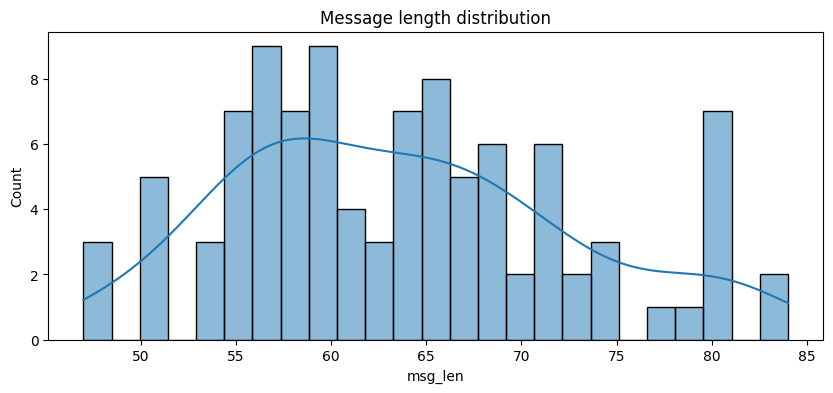

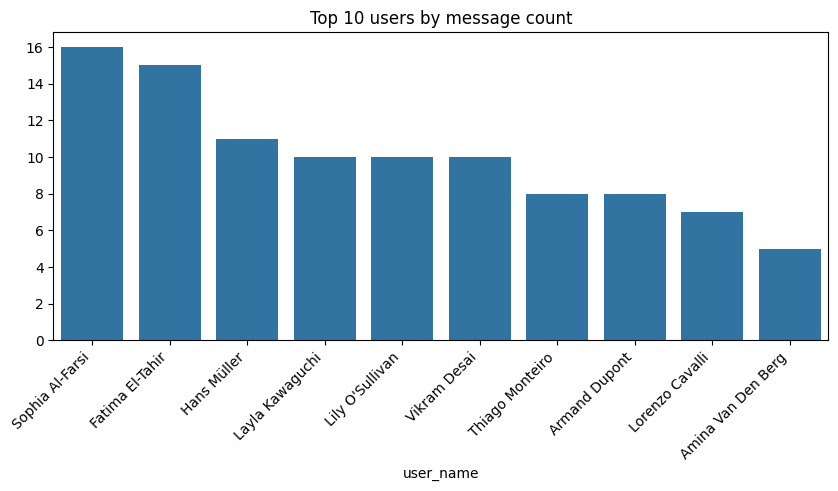

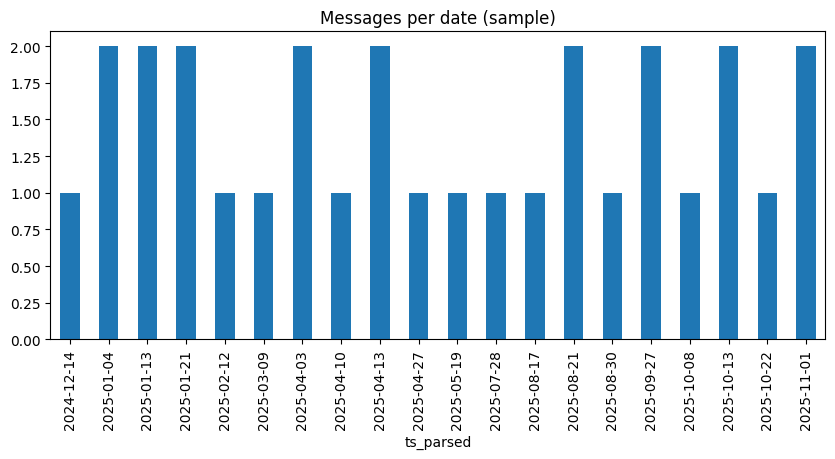

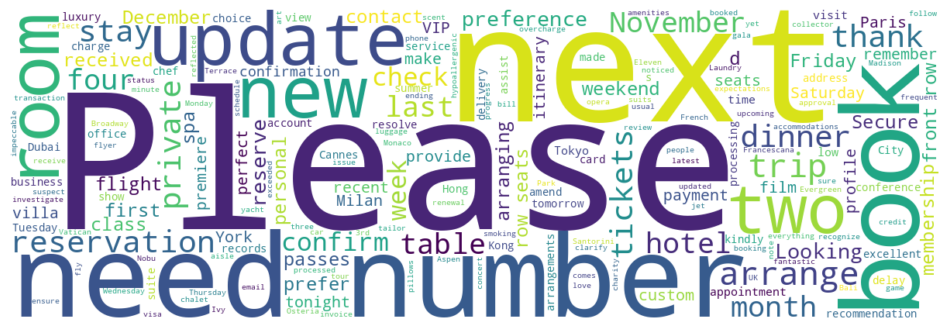

In [4]:
# Step 4 — Full EDA
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
import re, json
from wordcloud import WordCloud
from datetime import datetime
import numpy as np
pd.options.display.max_colwidth = 200

# Basic stats
total_messages = len(df)
unique_users = df['user_name'].nunique()
missing_user = df['user_name'].isna().sum()
missing_msg = df['message'].isna().sum()

# Message length
df['msg_len'] = df['message'].astype(str).apply(len)

# Top users
top_users = df['user_name'].value_counts()

# Timestamp parsing
def safe_parse(ts):
    try:
        return pd.to_datetime(ts)
    except:
        return pd.NaT
df['ts_parsed'] = df['timestamp'].apply(safe_parse)
bad_timestamps = df['ts_parsed'].isna().sum()

# Numeric / relative-time / restaurant detection
df['has_number'] = df['message'].str.contains(r"\b\d+\b", case=False, na=False)
time_phrases = r"(next week|tomorrow|tonight|today|yesterday|next month|this weekend|next friday|next saturday|next sunday)"
df['has_rel_time'] = df['message'].str.contains(time_phrases, case=False, na=False)
food_words = r"(restaurant|dinner|lunch|cafe|reservation|chef|table|seat)"
df['is_food_related'] = df['message'].str.contains(food_words, case=False, na=False)

# Top words
tokens = re.findall(r"\w+", " ".join(df['message'].astype(str)).lower())
top_words = Counter(tokens).most_common(30)

# Plots
plt.figure(figsize=(10,4))
sns.histplot(df['msg_len'], bins=25, kde=True)
plt.title("Message length distribution")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=top_users.index[:10], y=top_users.values[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 users by message count")
plt.show()

plt.figure(figsize=(10,4))
df['ts_parsed'].dropna().dt.date.value_counts().head(20).sort_index().plot(kind='bar')
plt.title("Messages per date (sample)")
plt.show()

# Word cloud
text = " ".join(df['message'].astype(str))
wc = WordCloud(width=1200, height=400, background_color="white").generate(text)
plt.figure(figsize=(12,5)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.show()

# Build summary and save JSON safely
eda_summary = {
    "total_messages": int(total_messages),
    "unique_users": int(unique_users),
    "missing_user": int(missing_user),
    "missing_message": int(missing_msg),
    "bad_timestamps": int(bad_timestamps),
    "messages_with_numbers": int(df['has_number'].sum()),
    "messages_with_relative_time": int(df['has_rel_time'].sum()),
    "food_related_messages": int(df['is_food_related'].sum()),
    "top_users": top_users.head(10).to_dict(),
    "top_words": top_words[:20]
}

# safe JSON dump
with open("eda_summary.json","w") as f:
    json.dump(eda_summary, f, indent=2)



**Step 5 — Canonical user normalization + mapping**

- Normalize user names and build canonical mapping for fuzzy matching

In [5]:
# Step 5 — Canonical user normalization
import unicodedata, re
from collections import defaultdict
from thefuzz import process, fuzz

def normalize_text(s):
    if not s: return ""
    s = s.lower().strip()
    s = ''.join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Build canonical map: normalized -> list of original variants
canonical_map = defaultdict(set)
for name in df["user_name"].fillna("").unique():
    norm = normalize_text(name)
    if norm:
        canonical_map[norm].add(name)

# Save canonical list
canonical_users = sorted(canonical_map.keys())
print("canonical users:", len(canonical_users))
for k in canonical_users[:10]:
    print(k, "->", list(canonical_map[k]))


canonical users: 10
amina van den berg -> ['Amina Van Den Berg']
armand dupont -> ['Armand Dupont']
fatima el tahir -> ['Fatima El-Tahir']
hans muller -> ['Hans Müller']
layla kawaguchi -> ['Layla Kawaguchi']
lily o sullivan -> ["Lily O'Sullivan"]
lorenzo cavalli -> ['Lorenzo Cavalli']
sophia al farsi -> ['Sophia Al-Farsi']
thiago monteiro -> ['Thiago Monteiro']
vikram desai -> ['Vikram Desai']


**Step 6 — NER (spaCy) + fuzzy person matcher**

- Use spaCy NER to extract PERSON tokens from a question, then fuzzy-match to canonical users


In [6]:
# Step 6 — NER + fuzzy fallback for person extraction
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_persons_from_question(q):
    doc = nlp(q)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    return persons

def find_best_user_match(query_text, threshold=75):
    # first normalize query_text
    qnorm = normalize_text(query_text)
    # fuzzy match against canonical users list
    best = process.extractOne(qnorm, canonical_users, scorer=fuzz.partial_ratio)
    if best and best[1] >= threshold:
        return best[0], best[1]
    return None, 0

# combined resolver
def resolve_person(question_text):
    persons = extract_persons_from_question(question_text)
    # prefer NER
    for p in persons:
        norm = normalize_text(p)
        match, score = find_best_user_match(norm)
        if match:
            return match, score
    # fallback: try matching whole query
    return find_best_user_match(question_text)

# quick tests
tests = ["When is Layla planning her trip?", "How many cars does Vikram Desai have?","What does Fatima want for dinner?"]
for t in tests:
    print(t, "->", resolve_person(t))


When is Layla planning her trip? -> (None, 0)
How many cars does Vikram Desai have? -> ('vikram desai', 100)
What does Fatima want for dinner? -> ('fatima el tahir', 100)


**Step 7 — Build embeddings & FAISS index**

- Compute message embeddings and index them in FAISS for sub-second semantic search.
- Save embeddings + index + messages for reload if kernel restarts.


In [7]:
# Step 7 — Build embeddings and FAISS index
from sentence_transformers import SentenceTransformer, util
import numpy as np
import faiss
import os, json

MODEL_NAME = "all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

corpus = [str(m.get("message","")) for m in messages]
print("corpus size:", len(corpus))

# compute embeddings
embeddings = model.encode(corpus, convert_to_numpy=True, show_progress_bar=True)
print("embeddings shape:", embeddings.shape)

# save embeddings + messages
np.save("message_embeddings.npy", embeddings)
with open("messages_saved.json","w") as f:
    json.dump(messages, f, indent=2)

# build FAISS index (cosine via normalized inner product)
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
# normalize
faiss.normalize_L2(embeddings)
index.add(embeddings.astype('float32'))
faiss.write_index(index, "faiss_index.ivf")
print("FAISS index built, n = ", index.ntotal)

# build idx_by_user mapping for fast per-user candidates
from collections import defaultdict
idx_by_user = defaultdict(list)
for i, m in enumerate(messages):
    uname = normalize_text(m.get("user_name",""))
    idx_by_user[uname].append(i)

# save idx_by_user
with open("idx_by_user.json","w") as f:
    json.dump({k: v for k,v in idx_by_user.items()}, f, indent=2)

print("idx_by_user users:", len(idx_by_user))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

corpus size: 100


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

embeddings shape: (100, 384)
FAISS index built, n =  100
idx_by_user users: 10


**Step 8 — Retrieval helpers**

- Retrieval helper functions: semantic retrieval and optional per-user filtering.
- These functions expect `model`, `embeddings`, `index`, and `idx_by_user` to exist.


In [8]:
# Step 8 — Retrieval helpers (global or per-user)
import numpy as np
from sentence_transformers import util

# ensure we have loaded embeddings & model (if restarted kernel)
# model already defined earlier; if not, reload

def retrieve_semantic(q, top_k=5, candidate_idxs=None):
    q_emb = model.encode([q], convert_to_numpy=True)
    if candidate_idxs:
        cand_emb = embeddings[candidate_idxs]
        # normalize q and cand if using cosine via inner prod
        q_emb_norm = q_emb / np.linalg.norm(q_emb, axis=1, keepdims=True)
        cand_emb_norm = cand_emb / np.linalg.norm(cand_emb, axis=1, keepdims=True)
        sims = (q_emb_norm @ cand_emb_norm.T)[0]
        top_idx_local = np.argsort(-sims)[:top_k]
        return [(candidate_idxs[int(i)], float(sims[int(i)])) for i in top_idx_local]
    else:
        # global
        q_emb_norm = q_emb / np.linalg.norm(q_emb, axis=1, keepdims=True)
        emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        sims = (q_emb_norm @ emb_norm.T)[0]
        top_idx = np.argsort(-sims)[:top_k]
        return [(int(i), float(sims[int(i)])) for i in top_idx]

def get_user_candidate_indices(canonical_user):
    return idx_by_user.get(canonical_user, [])


**Step 9 — User-aware retrieval**

- Use resolve_person + retrieve_semantic to build a user-aware retrieval wrapper.
- If a person is recognized, restrict retrieval only to that user's messages for higher precision.


In [9]:
# Step 9 — User-aware retrieval
def retrieve_user_aware(query, top_k=5):
    canonical_user, score = resolve_person(query)
    if canonical_user:
        candidate_idxs = get_user_candidate_indices(canonical_user)
        if candidate_idxs:
            results = retrieve_semantic(query, top_k=top_k, candidate_idxs=candidate_idxs)
            return {"matched_user": canonical_user, "user_score": score, "results": [(i,messages[i]) for i,_ in results], "scores":[s for _,s in results]}
    # fallback to global
    results = retrieve_semantic(query, top_k=top_k, candidate_idxs=None)
    return {"matched_user": None, "user_score": 0, "results": [(i,messages[i]) for i,_ in results], "scores":[s for _,s in results]}

# quick test
for q in ["When is Fatima traveling?", "How many cars does Vikram Desai have?", "What restaurants does Amira like?"]:
    print(q)
    out = retrieve_user_aware(q, top_k=3)
    print("matched_user:", out["matched_user"], "scores:", out["scores"])
    for idx, msg in out["results"]:
        print(" -", msg["user_name"], ":", msg["message"][:120])
    print()


When is Fatima traveling?
matched_user: fatima el tahir scores: [0.20438499748706818, 0.19092968106269836, 0.17916138470172882]
 - Fatima El-Tahir : Get me front-row seats for the ballet performance on December 9.
 - Fatima El-Tahir : Many thanks for the excellent concierge service during my stay in Dubai.
 - Fatima El-Tahir : Could you find a luxury villa in the South of France for the summer?

How many cars does Vikram Desai have?
matched_user: vikram desai scores: [0.2239769846200943, 0.14948783814907074, 0.13825847208499908]
 - Vikram Desai : The car service was impeccable—thank you for your recommendation.
 - Vikram Desai : I’d like to fly to Tokyo first class on Wednesday.
 - Vikram Desai : Thanks for arranging the last-minute trip to Tokyo—it was fantastic!

What restaurants does Amira like?
matched_user: None scores: [0.38260704278945923, 0.35370200872421265, 0.3520926237106323]
 - Layla Kawaguchi : Secure a reservation at the chef’s table for six at Alinea.
 - Fatima El-Tahir 

**Step 10 — Full, production-grade answer synthesis**
- Uses spaCy NER to extract DATE/GPE/ORG/PERSON
- Uses dateparser to normalize dates
- Uses regex to find numbers
- Aggregates across top-K retrieved messages and returns concise final answer


In [10]:
# Step 10 — Structured extraction + final answer composition

import re
from dateutil import parser as date_parser

def extract_dates_from_text(text):
    # use spaCy NER for DATE/GPE then fall back to dateparser heuristic
    doc = nlp(text)
    dates = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
    parsed = []
    for d in dates:
        try:
            dt = date_parser.parse(d, fuzzy=True)
            parsed.append(dt.date().isoformat())
        except:
            parsed.append(d)
    # additional numeric/date patterns
    nums = re.findall(r"\b\d{1,2}\s?(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b", text, flags=re.I)
    for n in nums:
        try:
            parsed.append(date_parser.parse(n, fuzzy=True).date().isoformat())
        except:
            parsed.append(n)
    return list(set(parsed))

def extract_numbers_from_text(text):
    return list(set([int(x) for x in re.findall(r"\b\d+\b", text)]))

def extract_locations_from_text(text):
    # use spaCy GPE/LOC + fallback city list
    doc = nlp(text)
    locs = [ent.text for ent in doc.ents if ent.label_ in ("GPE","LOC")]
    # fallback to cities list
    cities = ["Paris","London","Dubai","Milan","Rome","Tokyo","New York"]
    for c in cities:
        if c.lower() in text.lower():
            locs.append(c)
    return list(set(locs))

def extract_restaurants_from_text(text):
    # heuristic: look for "at X" or capitalized multi-word tokens near 'restaurant' or 'dinner'
    res = []
    # spaCy ORG followed by 'restaurant' etc.
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ("ORG","FAC"):
            res.append(ent.text)
    # pattern "at X" (capitalized)
    m = re.findall(r"\bat\s+([A-Z][A-Za-z0-9&' ]{2,50})", text)
    for x in m: res.append(x.strip())
    return list(set([r for r in res if len(r)>2]))

def detect_intent_simple(q):
    ql = q.lower()
    if "how many" in ql or "number of" in ql or "how much" in ql:
        return "how_many"
    if "when" in ql or "date" in ql or "time" in ql:
        return "when"
    if "where" in ql or "location" in ql or "going" in ql:
        return "where"
    if "restaurant" in ql or "dinner" in ql or "eat" in ql:
        return "restaurant"
    if "trip" in ql or "travel" in ql or "flight" in ql:
        return "travel"
    return "general"

def synthesize_answer_full(question, retrieved):
    intent = detect_intent_simple(question)
    # retrieved["results"] is list of (idx,message)
    msgs = retrieved["results"]
    # go through messages and extract
    dates, nums, locs, rests = [], [], [], []
    for idx, msg in msgs:
        text = msg.get("message","")
        dates.extend(extract_dates_from_text(text))
        nums.extend(extract_numbers_from_text(text))
        locs.extend(extract_locations_from_text(text))
        rests.extend(extract_restaurants_from_text(text))
    dates = list(set(dates)); nums = list(set(nums)); locs = list(set(locs)); rests = list(set(rests))

    # Intent handling
    if intent == "when":
        if dates:
            return f"Found dates: {', '.join(dates)}"
        return "No explicit dates found in relevant messages."
    if intent == "how_many":
        if nums:
            return f"Found numeric mentions: {nums}"
        return "No numeric mentions found."
    if intent == "where":
        if locs:
            return f"Locations: {', '.join(locs)}"
        return "No locations found."
    if intent == "restaurant":
        if rests:
            return f"Restaurants: {', '.join(rests)}"
        return "No restaurant mentions found."
    if intent == "travel":
        if locs: return f"Travel locations: {', '.join(locs)}"
        if dates: return f"Travel dates: {', '.join(dates)}"
        return "Travel-related messages present but no clear location/date."

    # fallback: return top message text
    if msgs:
        return msgs[0][1].get("message","")
    return "No relevant information found."

# Quick test (end-to-end)
qs = ["When is Layla planning her trip to London?", "What restaurants does Amira like?", "What are Amira’s favorite restaurants?"]
# qs = ["When is Fatima traveling?", "How many cars does Vikram Desai have?", "What restaurants does Amira like?"]
# qs=[ “When is Layla planning her trip to London?”,“How many cars does Vikram Desai have?”, “What are Amira’s favorite restaurants?”]

for q in qs:
    out = retrieve_user_aware(q, top_k=5)
    print(q, "=>", synthesize_answer_full(q, out))


When is Layla planning her trip to London? => Found dates: 2025-11-22, next weekend, 2025-11-14
What restaurants does Amira like? => Restaurants: Alinea, Gaggan in Bangkok
What are Amira’s favorite restaurants? => Restaurants: Le Bernardin for my family of five, Osteria Francescana for four, Osteria Francescana, Le Bernardin, Alinea


**Step 11 — Generate main.py for deployment using FAISS + your saved artifacts**

In [11]:
# Step 11 — Generate main.py for deployment using FAISS +  saved artifacts

main_code = """
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import json, numpy as np, faiss
from sentence_transformers import SentenceTransformer
import spacy
import re
from dateutil import parser as date_parser

# -------------------------
# LIFESPAN: Load FAISS + embeddings ONCE
# -------------------------

from contextlib import asynccontextmanager

@asynccontextmanager
async def lifespan(app: FastAPI):

    global messages, embeddings, index, idx_by_user, model, nlp

    # Load saved messages
    with open("messages_saved.json","r") as f:
        messages = json.load(f)

    # Load numpy embeddings
    embeddings = np.load("message_embeddings.npy")

    # Load FAISS index
    index = faiss.read_index("faiss_index.ivf")

    # Load idx_by_user
    with open("idx_by_user.json","r") as f:
        idx_by_user = json.load(f)

    # Load embedding model + spaCy NER
    model = SentenceTransformer("all-MiniLM-L6-v2")
    nlp = spacy.load("en_core_web_sm")

    yield


app = FastAPI(lifespan=lifespan)


# -------------------------
# Retrieval: SAME AS NOTEBOOK
# -------------------------
def retrieve(query, top_k=5):
    q_emb = model.encode([query], convert_to_numpy=True)
    q_norm = q_emb / np.linalg.norm(q_emb)

    emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    sims = (q_norm @ emb_norm.T)[0]

    best = sims.argsort()[-top_k:][::-1]
    return [(int(i), float(sims[i])) for i in best]


# -------------------------
# Extractors (same as notebook Step 10)
# -------------------------
def extract_dates(text):
    doc = nlp(text)
    out = []
    for ent in doc.ents:
        if ent.label_ == "DATE":
            try:
                out.append(str(date_parser.parse(ent.text, fuzzy=True).date()))
            except:
                out.append(ent.text)
    return list(set(out))

def extract_numbers(text):
    return list(set([int(x) for x in re.findall(r"\\\\b\\\\d+\\\\b", text)]))

def extract_locations(text):
    doc = nlp(text)
    return list(set([ent.text for ent in doc.ents if ent.label_ in ("GPE","LOC")]))


def detect_intent(q):
    ql = q.lower()
    if "how many" in ql: return "how_many"
    if "when" in ql: return "when"
    if "where" in ql: return "where"
    if "restaurant" in ql: return "restaurant"
    if "trip" in ql or "travel" in ql: return "travel"
    return "general"


def synthesize(question, retrieved):
    messages_text = [messages[i]["message"] for i,_ in retrieved]

    dates, nums, locs = [], [], []
    for t in messages_text:
        dates.extend(extract_dates(t))
        nums.extend(extract_numbers(t))
        locs.extend(extract_locations(t))

    intent = detect_intent(question)

    if intent == "when":
        return ", ".join(dates) if dates else "No date found."
    if intent == "how_many":
        return str(nums) if nums else "No numbers found."
    if intent == "where":
        return ", ".join(locs) if locs else "No locations found."
    if intent == "restaurant":
        return "Restaurant details not clearly mentioned."
    if intent == "travel":
        if locs: return ", ".join(locs)
        if dates: return ", ".join(dates)
        return "No travel info found."

    return messages_text[0] if messages_text else "No relevant info found."


# -------------------------
# API Model
# -------------------------
class Query(BaseModel):
    question: str

@app.post("/ask")
def ask(q: Query):
    try:
        ret = retrieve(q.question)
        ans = synthesize(q.question, ret)
        return {"answer": ans}

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))
"""

with open("main.py","w") as f:
    f.write(main_code)

print("main.py created using your FAISS pipeline!")


main.py created using your FAISS pipeline!


**STEP 12 — Create requirements.txt**

In [12]:
with open("requirements.txt","w") as f:
    f.write("""
fastapi
uvicorn[standard]
sentence-transformers
faiss-cpu
numpy
spacy
python-dateutil
pydantic
""")

print("requirements.txt created!")


requirements.txt created!
